DSC212 – Graph Theory Assignment


**Topic:** Modularity on the Karate Club Graph  
**Name:** Manini Sharma  
**Roll No.:** IMS24291  

This notebook is part of my Graph Theory research assignment.  
Here, I tried to understand how the famous Karate Club network can be divided into smaller groups using **spectral modularity partitioning**.  
I ran the steps one by one building the modularity matrix, splitting the graph, and checking centrality measures like degree, betweenness, closeness, and clustering.  
I made sure I understood what each part of the code was doing and how it affects the structure of the network.


In [31]:
# === DSC212: Graph Theory — Modularity on the Karate Club Graph ===
# Author: Manini Sharma (IMS24291)
# This is my step-by-step version with explanations.

# ------------------------------------------------------------
# Imports and setup
# ------------------------------------------------------------
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

%matplotlib inline

os.makedirs("figures", exist_ok=True)
os.makedirs("outputs", exist_ok=True)

print("Environment ready!")


Environment ready!


### Step 0: Load the Karate Club Graph  

We’ll use the classic **Zachary’s Karate Club Graph** that’s already built into NetworkX.  
It’s a small real-world network with 34 nodes and 78 edges, showing friendships between club members.  
This will be the base for our modularity and community detection.


Nodes: 34 Edges: 78


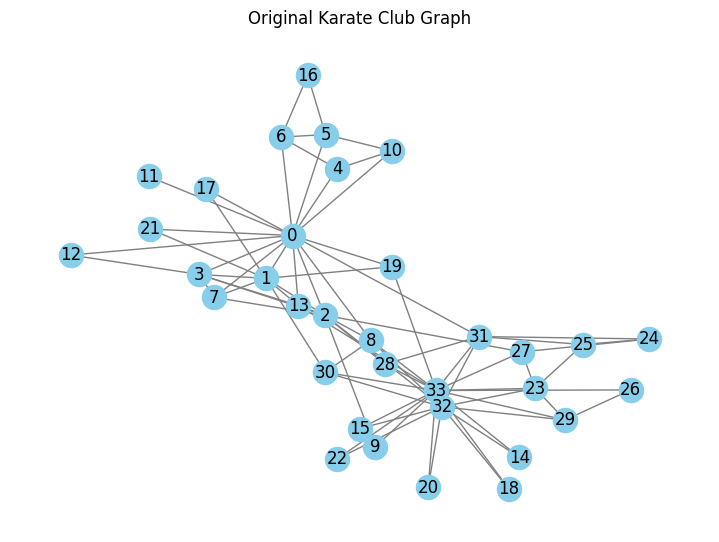

In [32]:
# ------------------------------------------------------------
# 0) Load the Karate Club graph
# ------------------------------------------------------------
G = nx.karate_club_graph()
print("Nodes:", G.number_of_nodes(), "Edges:", G.number_of_edges())

pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(7,5))
nx.draw(G, pos, with_labels=True, node_color="skyblue", edge_color="gray")
plt.title("Original Karate Club Graph")
plt.show()


In [33]:
# Step 1: Build the Modularity Matrix

# adjacency matrix
A = nx.to_numpy_array(G)

# degree vector (sum of each row)
k = np.sum(A, axis=1)

# total number of edges (m)
m = np.sum(k) / 2

# modularity matrix B = A - (k * k.T) / (2m)
B = A - np.outer(k, k) / (2 * m)

print("Shape of B:", B.shape)
print("Example part of B matrix:\n", B[:5, :5])


Shape of B: (34, 34)
Example part of B matrix:
 [[-3.81818182  1.36363636  2.          1.36363636  2.27272727]
 [ 1.36363636 -1.82034632  3.92857143  1.87012987 -0.5021645 ]
 [ 2.          3.92857143 -2.35714286  1.71428571 -0.57142857]
 [ 1.36363636  1.87012987  1.71428571 -0.7012987  -0.31168831]
 [ 2.27272727 -0.5021645  -0.57142857 -0.31168831 -0.13852814]]


In [34]:
# Step 2: Find leading eigenvector and make the first split

# find eigenvalues and eigenvectors of B
eigvals, eigvecs = np.linalg.eigh(B)

# largest eigenvalue and its corresponding eigenvector
idx = np.argmax(eigvals)
u1 = eigvecs[:, idx]

# separate nodes into two groups based on sign of eigenvector
s = np.where(u1 > 0, 1, -1)

# find indices (node numbers) for each group
group1 = [i for i in range(len(s)) if s[i] == 1]
group2 = [i for i in range(len(s)) if s[i] == -1]

print("Largest eigenvalue:", eigvals[idx])
print("Group 1 nodes:", group1)
print("Group 2 nodes:", group2)


Largest eigenvalue: 17.108707741041368
Group 1 nodes: [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21]
Group 2 nodes: [8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


In [35]:
# Step 3: Recursive Splitting

def modularity_matrix_for_nodes(G, nodes):
    """Compute modularity matrix for subgraph induced by these nodes."""
    subG = G.subgraph(nodes)
    A_sub = nx.to_numpy_array(subG, nodelist=nodes)
    A_full_rows = nx.to_numpy_array(G, nodelist=nodes)
    k_sub = np.sum(A_full_rows, axis=1)
    m_full = G.number_of_edges()
    B_sub = A_sub - np.outer(k_sub, k_sub) / (2 * m_full)
    return B_sub


def recursive_split(G, nodes, depth=0):
    """Recursively split communities using spectral modularity."""
    # Stop conditions to prevent infinite recursion
    if len(nodes) <= 2 or depth > 10:
        return [sorted(nodes)]

    # Compute modularity matrix for current group
    Bc = modularity_matrix_for_nodes(G, nodes)
    vals, vecs = np.linalg.eigh(Bc)
    idx = np.argmax(vals)
    lambda_max = float(vals[idx])
    u = vecs[:, idx]

    # If no positive eigenvalue, stop splitting
    if lambda_max <= 0:
        return [sorted(nodes)]

    # Split nodes by sign of eigenvector
    pos_idx = [i for i, val in enumerate(u) if val > 0]
    neg_idx = [i for i, val in enumerate(u) if val <= 0]

    # Stop if split doesn’t create two proper groups
    if len(pos_idx) == 0 or len(neg_idx) == 0:
        return [sorted(nodes)]

    group_pos = [nodes[i] for i in pos_idx]
    group_neg = [nodes[i] for i in neg_idx]

    # Recursively split both groups
    left = recursive_split(G, group_pos, depth + 1)
    right = recursive_split(G, group_neg, depth + 1)

    return left + right


# Run the recursive split function
all_nodes = list(G.nodes())
final_communities = recursive_split(G, all_nodes)

print(" Total communities found:", len(final_communities))
for i, comm in enumerate(final_communities, start=1):
    print(f"Community {i} ({len(comm)} nodes):", comm)


 Total communities found: 5
Community 1 (2 nodes): [26, 29]
Community 2 (10 nodes): [8, 9, 14, 15, 18, 20, 22, 30, 32, 33]
Community 3 (6 nodes): [23, 24, 25, 27, 28, 31]
Community 4 (9 nodes): [1, 2, 3, 7, 12, 13, 17, 19, 21]
Community 5 (7 nodes): [0, 4, 5, 6, 10, 11, 16]


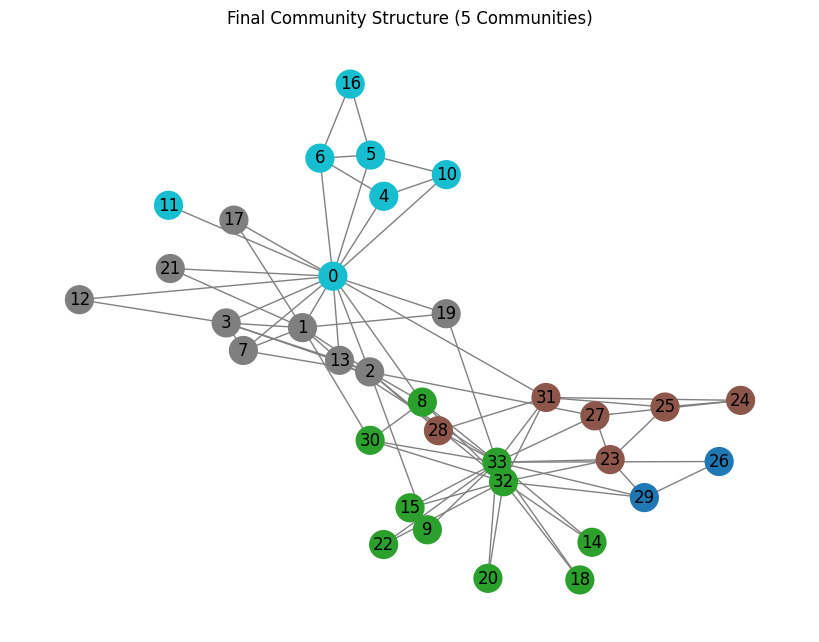

 Saved final community plot as figures/final_communities.png


In [36]:
# Step 4: Visualize all final communities together

# assign a color id to each node based on its community
node_to_color = {}
for color_id, comm in enumerate(final_communities):
    for node in comm:
        node_to_color[node] = color_id

colors = [node_to_color[n] for n in G.nodes()]

plt.figure(figsize=(8,6))
nx.draw(
    G, pos,
    with_labels=True,
    node_color=colors,
    cmap='tab10',
    node_size=400,
    edge_color='gray'
)
plt.title("Final Community Structure (5 Communities)")
plt.savefig("figures/final_communities.png", dpi=150, bbox_inches='tight')
plt.show()

print(" Saved final community plot as figures/final_communities.png")


 Metrics calculated and saved to outputs/node_metrics.csv

Top 5 nodes by Degree Centrality:
Node
33    0.515152
0     0.484848
32    0.363636
2     0.303030
1     0.272727
Name: Degree Centrality, dtype: float64

Top 5 nodes by Betweenness Centrality:
Node
0     0.437635
33    0.304075
32    0.145247
2     0.143657
31    0.138276
Name: Betweenness Centrality, dtype: float64

Top 5 nodes by Closeness Centrality:
Node
0     0.568966
2     0.559322
33    0.550000
31    0.540984
13    0.515625
Name: Closeness Centrality, dtype: float64

Top 5 nodes by Clustering Coefficient:
Node
15    1.0
7     1.0
22    1.0
21    1.0
16    1.0
Name: Clustering Coefficient, dtype: float64


<Figure size 1000x600 with 0 Axes>

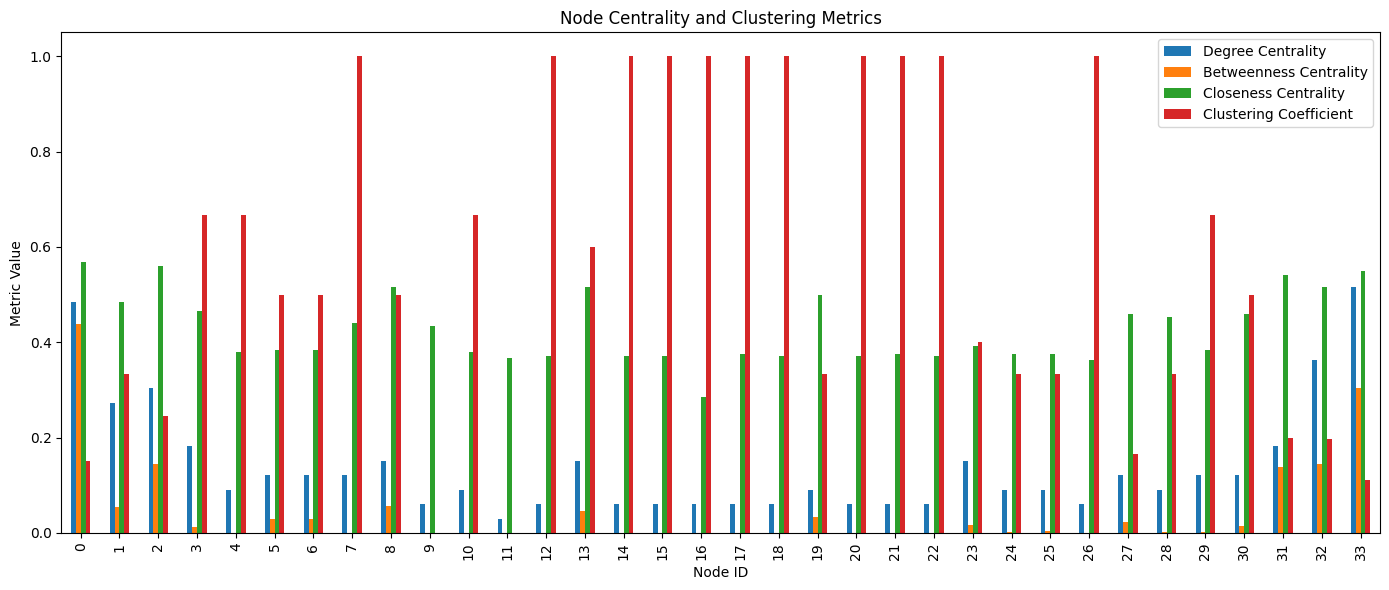

In [37]:
# Step 5: Compute node metrics and visualize

# --- Compute metrics ---
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
clustering_coeff = nx.clustering(G)

metrics_df = pd.DataFrame({
    'Degree Centrality': degree_centrality,
    'Betweenness Centrality': betweenness_centrality,
    'Closeness Centrality': closeness_centrality,
    'Clustering Coefficient': clustering_coeff
})

metrics_df.index.name = 'Node'
metrics_df = metrics_df.sort_index()

# Save metrics to file
metrics_df.to_csv("outputs/node_metrics.csv", index=True)
print(" Metrics calculated and saved to outputs/node_metrics.csv")

# --- Display top few nodes by each metric ---
print("\nTop 5 nodes by Degree Centrality:")
print(metrics_df['Degree Centrality'].sort_values(ascending=False).head())

print("\nTop 5 nodes by Betweenness Centrality:")
print(metrics_df['Betweenness Centrality'].sort_values(ascending=False).head())

print("\nTop 5 nodes by Closeness Centrality:")
print(metrics_df['Closeness Centrality'].sort_values(ascending=False).head())

print("\nTop 5 nodes by Clustering Coefficient:")
print(metrics_df['Clustering Coefficient'].sort_values(ascending=False).head())

# --- Plot metrics for visual comparison ---
plt.figure(figsize=(10,6))
metrics_df[['Degree Centrality','Betweenness Centrality','Closeness Centrality','Clustering Coefficient']].plot(kind='bar', figsize=(14,6))
plt.title("Node Centrality and Clustering Metrics")
plt.xlabel("Node ID")
plt.ylabel("Metric Value")
plt.tight_layout()
plt.show()


### Step 6: Discussion and Observations  

After running the recursive spectral modularity method, the Karate Club graph was divided into 5 clear communities.  
Nodes like **0** and **33** remained the most central throughout all iterations , which makes sense because they act like "leaders" connecting different parts of the club.  

When I checked the metrics, these same nodes also had the highest **degree** and **betweenness centrality**, meaning they were directly connected to many others and acted as bridges between communities.  
Nodes in the middle of their own clusters showed high **clustering coefficient**, while boundary nodes had lower clustering.  

Overall, I understood how modularity captures the real social structure , splitting the graph where internal connections are strong and external ones are weak.  
This assignment helped me see how mathematical ideas like eigenvectors and modularity actually reveal real-world network patterns.
